In [63]:
import pandas as pd
import scanpy as sc
from ast import literal_eval
import random
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import matplotlib
from matplotlib import rc_context
import scipy.stats as stats
from scipy.stats import ttest_ind
import numpy as np
import math

In [2]:
import glob
pattern = '../**/*.ipynb'
query = 'cell-type-distribution.pdf'

for filepath in glob.iglob(pattern, recursive=True):
    with open(filepath) as file:
        s = file.read()
        if (s.find(query) > -1):
            print(filepath)

../paper-figures/paper-figure2-2-cell-comparison.ipynb


In [3]:
# Load data
clones = pd.read_csv('../../data/lineage-barcodes/targeted-barcodes/20210128_clone_df_mincut_multicut.csv',
                    converters={'Cells':literal_eval}, index_col=0)
adata = sc.read('../../data/adata/LBC-EHT-sep-reg-ccreg-ct-update-sigs-added-index-proper.h5ad')

In [4]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.settings.figdir = '../../data/paper-figures/'
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

scanpy==1.9.3 anndata==0.7.6 umap==0.4.6 numpy==1.21.2 scipy==1.6.0 pandas==1.2.2 scikit-learn==1.0.2 statsmodels==0.12.1 python-igraph==0.8.2 louvain==0.7.0 pynndescent==0.4.8


In [5]:
old_to_new = {
    'Endothelial Cells':'Endothelial Cells',
    "Erythroid Cells":'Erythroid Progenitors',
    'Mast Cells':'Mast Progenitors',
    'Myeloid Cells':'Myeloid Progenitors',
    'Progenitor Cells':'MPP/HSC',
    'ProT Cells':'Progenitor T Cells'
}
adata.obs['Cell Types'] = (
    adata.obs['Cell Types']
    .map(old_to_new)
    .astype('category')
)

In [6]:
adata.uns['Cell Types_colors'] = ['tab:cyan', 'tab:red', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown']

In [7]:
T2 = adata[adata.obs['dataset'].isin(['T2'])]

In [8]:
# Make T2 dataset
T2_clones = pd.DataFrame(columns=['Cells', 'Num Cells', 'Cell Types'])
for x in clones.index:
    t1 = len([i for i in clones['Cells'][x] if i.endswith('T1') and i in adata.obs_names])
    t2 = [i for i in clones['Cells'][x] if i.endswith('T2') and i in adata.obs_names]
    t2_num = len(t2)
    if t2_num > 0:
        ct = adata[adata.obs_names.isin(t2)].obs['Cell Types'].to_dict()
        T2_clones.loc[x] = [t2, t2_num, ct]

# Make T1 dataset
T1_clones = pd.DataFrame(columns=['Cells', 'Num Cells', 'Cell Types'])
for x in clones.index:
    t1 = [i for i in clones['Cells'][x] if i.endswith('T1') and i in adata.obs_names]
    t1_num = len(t1)
    t2 = [i for i in clones['Cells'][x] if i.endswith('T2') and i in adata.obs_names]
    t2_num = len(t2)
    if t1_num > 0:
        ct = adata[adata.obs_names.isin(t1)].obs['Cell Types'].to_dict()
        T1_clones.loc[x] = [t1, t1_num, ct]

In [9]:
T2_clones

,Cells,Num Cells,Cell Types
Clone_1,[ATTTCTGCACGACGTC_T2],1,{'ATTTCTGCACGACGTC_T2': 'Mast Progenitors'}
Clone_4,"[AGATAGAGTCTGTAAC_T2, CATAAGCGTGAGTGAC_T2, TAC...",11,"{'AAGTGAACAACGATCT_T2': 'Progenitor T Cells', ..."
Clone_6,[AGTGACTTCAACTTTC_T2],1,{'AGTGACTTCAACTTTC_T2': 'Mast Progenitors'}
Clone_8,"[TGCTCCATCATTACCT_T2, GATCACAAGATCGCCC_T2]",2,"{'GATCACAAGATCGCCC_T2': 'Myeloid Progenitors',..."
Clone_9,"[TTAGGGTTCCTCCACA_T2, CATTGAGCAGAGGCAT_T2]",2,"{'CATTGAGCAGAGGCAT_T2': 'Myeloid Progenitors',..."
...,...,...,...
Clone_1375,"[GGTGGCTCACTAACGT_T2, TTCCTTCAGTGGTGAC_T2, ATC...",3,"{'ATCGTAGTCGCAGATT_T2': 'Mast Progenitors', 'G..."
Clone_1376,[TTGAGTGAGAACAAGG_T2],1,{'TTGAGTGAGAACAAGG_T2': 'Progenitor T Cells'}
Clone_1379,[ACAGCCGGTACTGAGG_T2],1,{'ACAGCCGGTACTGAGG_T2': 'Mast Progenitors'}
Clone_1381,"[CTATCCGAGTAACCGG_T2, TGTCCACGTATCGATC_T2]",2,"{'CTATCCGAGTAACCGG_T2': 'Progenitor T Cells', ..."


Define Functions for this analysis

Steps:

a) Sample 2 cells n times from the T2_multitime clone dataset

b) Do the following q times:

    i. Create a random dataframe of clones - same size as real dataset and same clonesize distribution
    
    ii. Sample n times from that dataframe
    
    iii. Count the number of times each pair appeared
    
    iv. Add that to a table

clones_df -> must have index of clone number, and columns 'Cells'=cell barcodes, 'Cell Types'=dict of cell types,
'Num Cells'=number of cells

In [10]:
# Sampling function

# Right now we are choosing based on cells - this biases it towards larger clones
def sample_clones(n_samples, clones_df):
    
    # Need to remove all clones that only have 1 cell in T2 - can't perform comparison
    # This may reduce the number of clones to a small number
    clones_df = clones_df[clones_df['Num Cells'] > 1]
    
    i=0
    # Make cell to clone directory
    look_up_dict = {}
    for x in clones_df.index:
        for y in clones_df['Cells'][x]:
            look_up_dict[y] = x
    cell_list = list(look_up_dict.keys())
    
    # Complete 2 cell comparison and add to dictionary
    cell_comp_dict = {}
    while i < n_samples:
        cell1 = random.choice(cell_list)
        clone_name = look_up_dict[cell1]
        tmp_list = [c for c in clones_df['Cells'][clone_name] if c!=cell1]
        cell2 = random.choice(tmp_list)
        cts_2 = [clones_df['Cell Types'][clone_name][i] for i in [cell1, cell2]]
        cts_2.sort()
        cts_2_str = '_'.join(cts_2)
        if cts_2_str not in cell_comp_dict:
            cell_comp_dict[cts_2_str] = 1
        else:
            cell_comp_dict[cts_2_str] += 1
        i+=1
    cell_df = pd.DataFrame.from_dict(cell_comp_dict, orient='index', columns=['Count']).sort_index()
    return cell_df

In [11]:
# Generate Simulated dataframe

# Right now, the function is including all the cells in the T2 dataset:
#     This can be changed to include only cells in multitime clones, or only cells that are barcoded
def generate_sim_clone(adata, num_cell_dist, name):
    ct_df = adata.obs[['Cell Types']]
    barcodes = list(ct_df.index)
    sim = pd.DataFrame(columns=['Cells', 'Num Cells', 'Cell Types'])
    for t, n in enumerate(num_cell_dist):
        barcodes = random.sample(list(ct_df.index), k=n)
        sim_ct_dict = {g:ct_df['Cell Types'][g] for g in barcodes}
        sim.loc[name+str(t)] = [barcodes, n, sim_ct_dict]
    return sim

In [12]:
# Generate Dataframe then perform 2 cell simulation on it, then add counts to master dataframe

def iterate_sims(q_dfs, n_samples, adata, num_cell_dist):
    i = 0
    master_sim = {}
    col_lab = []
    while i<q_dfs:
        sim = generate_sim_clone(adata, num_cell_dist, 'Clone_'+str(i)+'_')
        samples = sample_clones(n_samples, sim)
        col_lab.append('Clone_'+str(i))
        
        for k in samples.index:
            if k not in master_sim:
                master_sim[k] = [0]*i+[samples['Count'][k]]
            else:
                master_sim[k].append(samples['Count'][k])

        max_len = max(map(len, master_sim.values()))
        for k in master_sim:
            if len(master_sim[k]) < max_len:
                master_sim[k].append(0)
        i+=1
    master_sim_df = pd.DataFrame.from_dict(master_sim, orient='index', columns=col_lab)
    return master_sim_df

In [13]:
# sim should be output of iterate sims
def combine_real_and_sim(real, sim):
    sim = sim.mean(axis=1).to_frame()
    sim.columns = ['Count']
    df = pd.DataFrame([[real['Count'][x]/sim['Count'][x],
                         real['Count'][x], sim['Count'][x]] for x in real.index],
                      index=real.index, columns=['Real/Sim', 'Real', 'Sim'])
    return df

# Run pipeline


### Need to do this with all the T2 cells - this is more robust

b) T2 clones with T2 cells as simulated sample

In [14]:
# make proper adata
T2_cells = []
for x in T2_clones['Cells']:
    T2_cells += x

T2_adata = T2[T2.obs_names.isin(T2_cells)]

In [15]:
n_comps = 20000

# Two cell comparison for real dataset
real_comp = sample_clones(n_comps, T2_clones)
print('Completed Real Comp')
# Get sim dataset
t2_dist = list(T2_clones[T2_clones['Num Cells']>1]['Num Cells'])
sim = iterate_sims(1500, n_comps, T2_adata, t2_dist)

real_sim_2 = combine_real_and_sim(real_comp, sim)

Completed Real Comp


In [16]:
sim_2 = sim.copy()
sim_2 = sim_2[sim_2.index.isin(real_comp.index)]

In [17]:
sim_2 = sim_2.reindex(real_comp.index, )

In [18]:
for x in sim_2.index:
    sim_2.loc[x] = [real_comp['Count'][x]/y for y in sim_2.loc[x]]

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [19]:
real_sim_2['T2 all'] = real_sim_2['Real/Sim']
real_sim_2['Multitime'] = real_sim_2['Real/Sim']

Plot

In [20]:
sim_2 = sim_2.transpose()

In [50]:
std = pd.Series()
ci = pd.Series()
for x in sim_2.columns:
    tmp = stats.t.interval(alpha=0.95,
                               df=len(sim_2[x])-1,
                               loc=np.mean(sim_2[x]),
                               scale=stats.sem(sim_2[x]))
    ci.loc[x] = (tmp[1] - tmp[0]) / 2
    std.loc[x] = np.std(sim_2[x])

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [56]:
# compute p values
cols = list(sim_2.columns)
ttest_results = pd.DataFrame(columns=['t-stat', 'pvals'])
for i in range(len(cols)):
    for x in range(len(cols)):
        pval = ttest_ind(sim_2[cols[i]], sim_2[cols[x]])
        ttest_results.loc[cols[i]+'|'+cols[x]] = list(pval)

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5452: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


In [60]:
ttest_results.to_csv('../../data/lineage-barcodes/targeted-barcodes/ttest_results-2cell-comp.csv')

In [57]:
ttest_results

,t-stat,pvals
Erythroid Progenitors_Erythroid Progenitors|Erythroid Progenitors_Erythroid Progenitors,NaN,NaN
Erythroid Progenitors_Erythroid Progenitors|Erythroid Progenitors_Mast Progenitors,NaN,NaN
Erythroid Progenitors_Erythroid Progenitors|Erythroid Progenitors_Progenitor T Cells,NaN,NaN
Erythroid Progenitors_Erythroid Progenitors|MPP/HSC_MPP/HSC,NaN,NaN
Erythroid Progenitors_Erythroid Progenitors|MPP/HSC_Mast Progenitors,NaN,NaN
...,...,...
Progenitor T Cells_Progenitor T Cells|Mast Progenitors_Myeloid Progenitors,442.578551,0.000000e+00
Progenitor T Cells_Progenitor T Cells|Mast Progenitors_Progenitor T Cells,409.531785,0.000000e+00
Progenitor T Cells_Progenitor T Cells|Myeloid Progenitors_Myeloid Progenitors,-37.317871,1.087327e-250
Progenitor T Cells_Progenitor T Cells|Myeloid Progenitors_Progenitor T Cells,348.085662,0.000000e+00


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


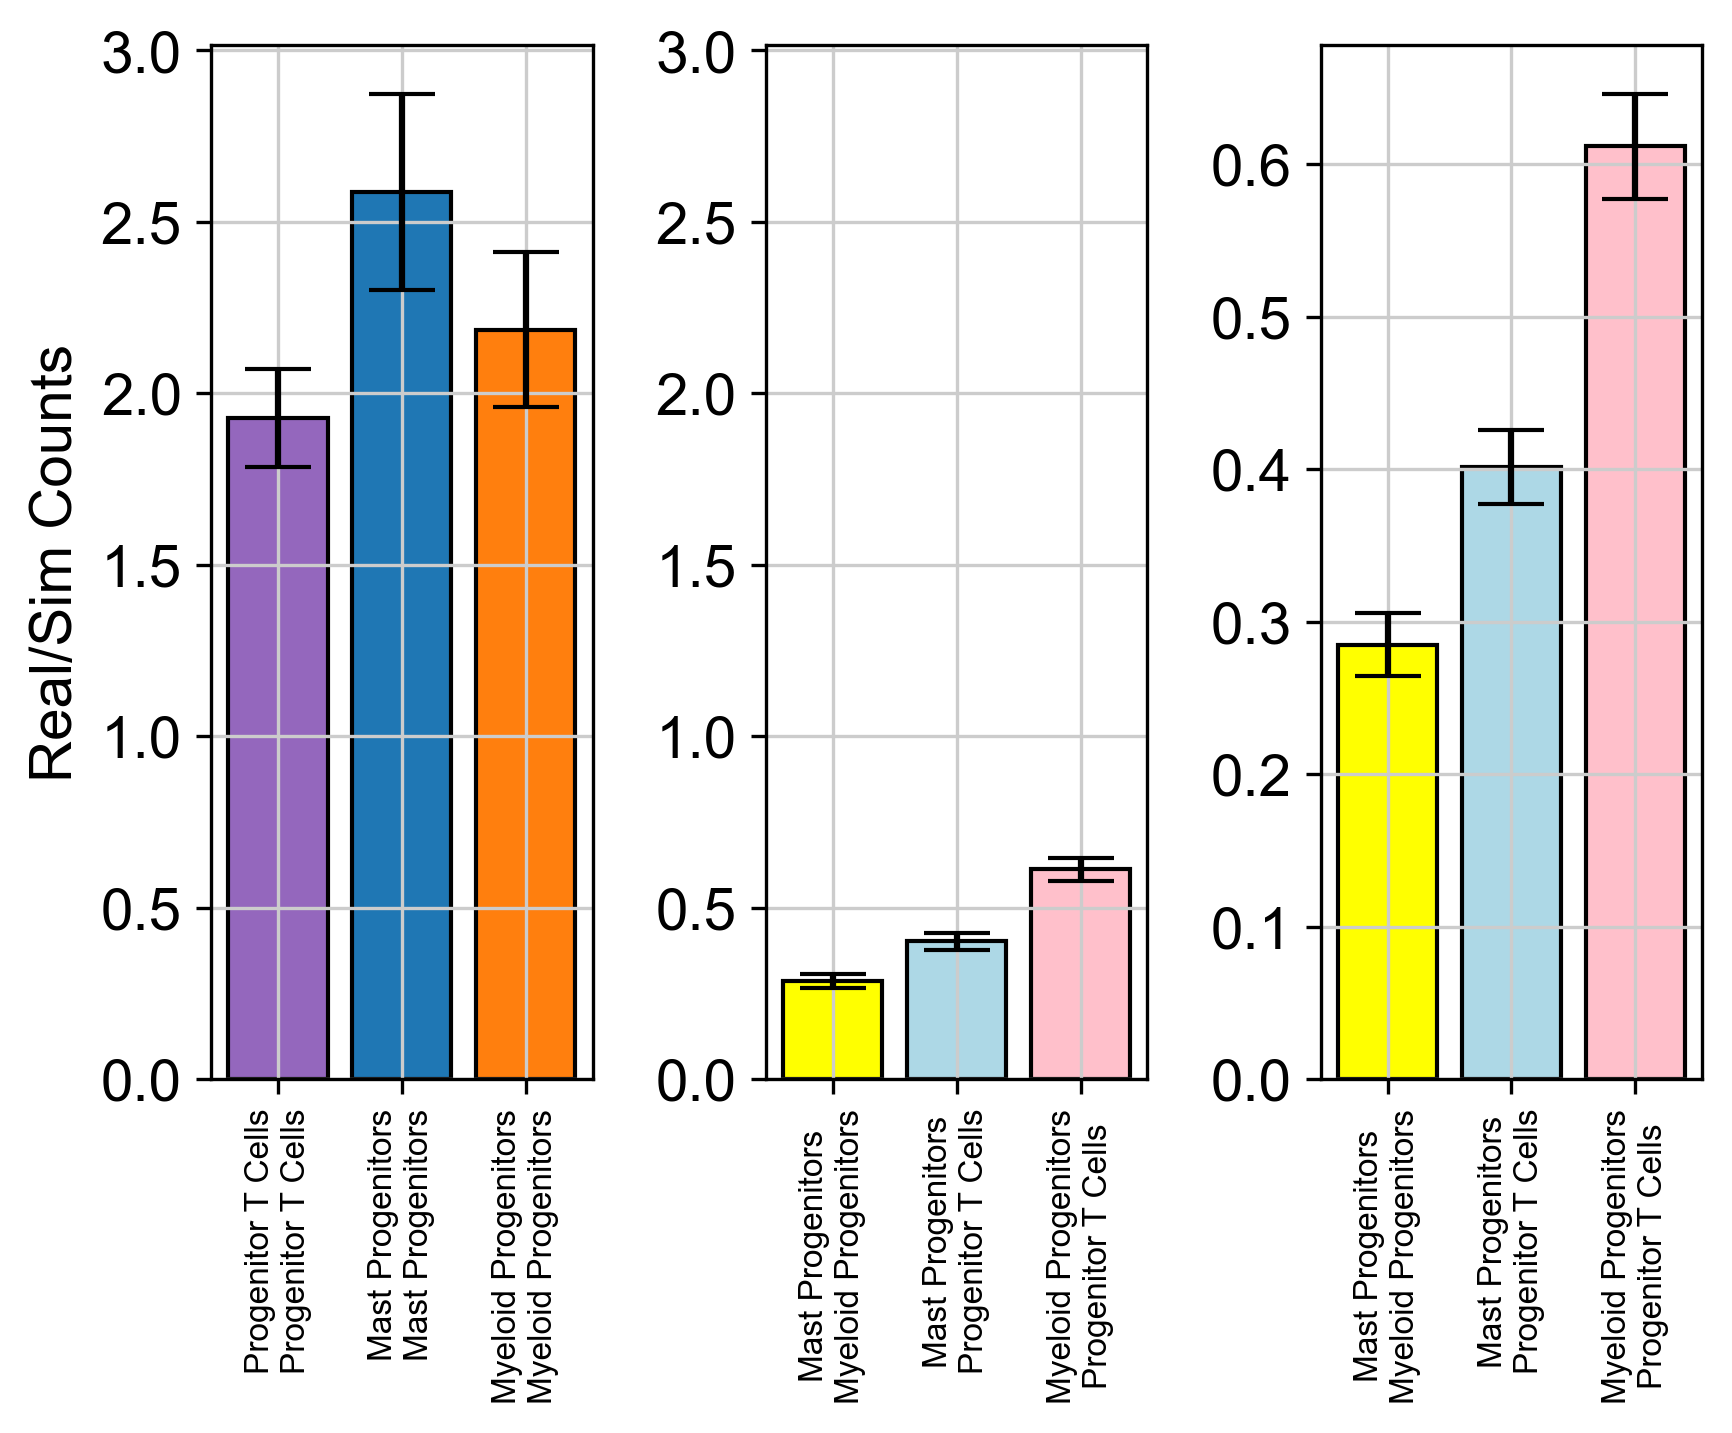

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 5))
same_cols = ['Progenitor T Cells_Progenitor T Cells', 'Mast Progenitors_Mast Progenitors',
             'Myeloid Progenitors_Myeloid Progenitors']
mean = sim_2.mean()
#mean.index = [old_to_new[x.split('_')[0]]+'_'+old_to_new[x.split('_')[1]] for x in mean.index]
#std.index = [old_to_new[x.split('_')[0]]+'_'+old_to_new[x.split('_')[1]] for x in std.index]
#real_sim_2.index = [old_to_new[x.split('_')[0]]+'_'+old_to_new[x.split('_')[1]] for x in real_sim_2.index]
ax[0].bar(x=same_cols, height=[mean[x] for x in same_cols],
          color=['tab:purple', 'tab:blue', 'tab:orange'], yerr=[std[x] for x in same_cols],
          edgecolor='black', capsize=8)
ax[0].set_xticks(same_cols)
labels = [x.split('_')[0]+'\n'+x.split('_')[1] for x in same_cols]
ax[0].set_xticklabels(labels, rotation=90, fontsize=8)
ax[0].set_ylabel('Real/Sim Counts')
compare_cols = ['Mast Progenitors_Myeloid Progenitors', 'Mast Progenitors_Progenitor T Cells',
                'Myeloid Progenitors_Progenitor T Cells']
ax[1].sharey(ax[0])
ax[1].bar(x=compare_cols, height=[real_sim_2['Real/Sim'][x] for x in compare_cols],
          color=['yellow', 'lightblue', 'pink'], yerr=[std[x] for x in compare_cols],
          edgecolor='black', capsize=8)
labels = [x.split('_')[0]+'\n'+x.split('_')[1] for x in compare_cols]
ax[1].set_xticklabels(labels, rotation=90, fontsize=8)
ax[2].bar(x=compare_cols, height=[real_sim_2['Real/Sim'][x] for x in compare_cols],
          color=['yellow', 'lightblue', 'pink'], yerr=[std[x] for x in compare_cols],
          edgecolor='black', capsize=8)
ax[2].set_xticklabels(labels, rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig('../../data/paper-figures/2cell-comp-barplot-allcombos.pdf', dpi=150)
plt.show()

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


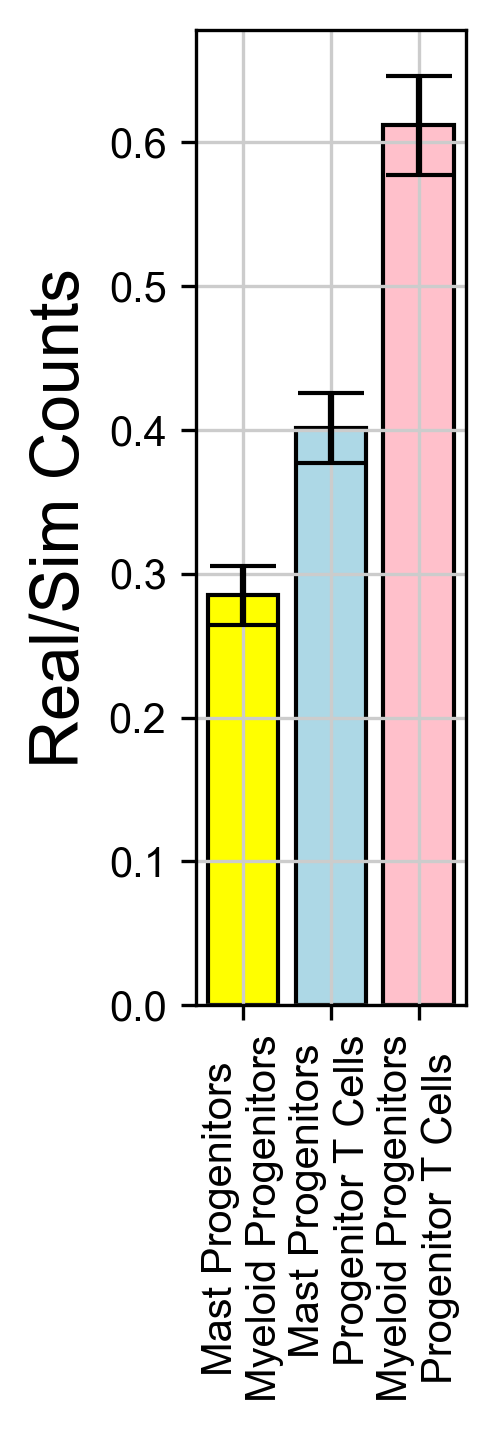

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.875,5))
ax.set_ylabel('Real/Sim Counts', fontsize=16)
compare_cols1 = ['Mast Cells\nMyeloid Cells', 'Mast Cells\nProT Cells', 'Myeloid Cells\nProT Cells']
compare_cols = ['Mast Progenitors_Myeloid Progenitors', 'Mast Progenitors_Progenitor T Cells',
                'Myeloid Progenitors_Progenitor T Cells']
ax.bar(x=compare_cols, height=[real_sim_2['Real/Sim'][x] for x in compare_cols],
          color=['yellow', 'lightblue', 'pink'], yerr=[std[x] for x in compare_cols],
      width=0.8, edgecolor='black', capsize=8)
labels = [x.split('_')[0]+'\n'+x.split('_')[1] for x in compare_cols]
ax.set_xticklabels(labels, rotation=90, fontsize=10,)
ax.set_yticklabels(labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../data/paper-figures/2cell_comp-barplot-between-cts.pdf', dpi=150)
plt.show()

In [ ]:
real_sim_2

In [64]:
math.log2(real_sim_2['Real/Sim']['Mast Progenitors_Progenitor T Cells'] / real_sim_2['Real/Sim']['Mast Progenitors_Myeloid Progenitors'])

0.4942069109861816

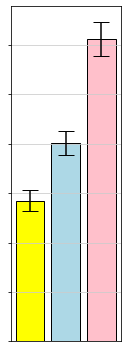

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.875,5))
ax.set_ylabel('Real/Sim Counts', fontsize=16)
compare_cols1 = ['Mast Cells\nMyeloid Cells', 'Mast Cells\nProT Cells', 'Myeloid Cells\nProT Cells']
compare_cols = ['Mast Progenitors_Myeloid Progenitors', 'Mast Progenitors_Progenitor T Cells',
                'Myeloid Progenitors_Progenitor T Cells']
ax.bar(x=compare_cols, height=[real_sim_2['Real/Sim'][x] for x in compare_cols],
          color=['yellow', 'lightblue', 'pink'], yerr=[std[x] for x in compare_cols],
      width=0.8, edgecolor='black', capsize=8)
ax.set_xticklabels(labels=[])
plt.xticks([])
ax.set_yticklabels([])
plt.ylabel('')
plt.grid(which='major', axis='x')
plt.tight_layout()
plt.savefig('../../data/paper-figures/2cell_comp-barplot-between-cts-no-xtick.pdf', dpi=150)
plt.show()

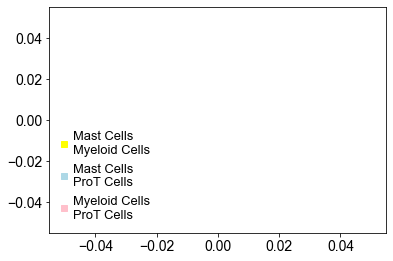

In [26]:
colors = ['yellow', 'lightblue', 'pink']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(3)]
labels = ['Mast Cells\nMyeloid Cells', 'Mast Cells\nProT Cells', 'Myeloid Cells\nProT Cells']
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

def export_legend(legend, filename="../../data/paper-figures/2cell-legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    plt.grid(False)
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=150, bbox_inches=bbox)

export_legend(legend)
plt.show()

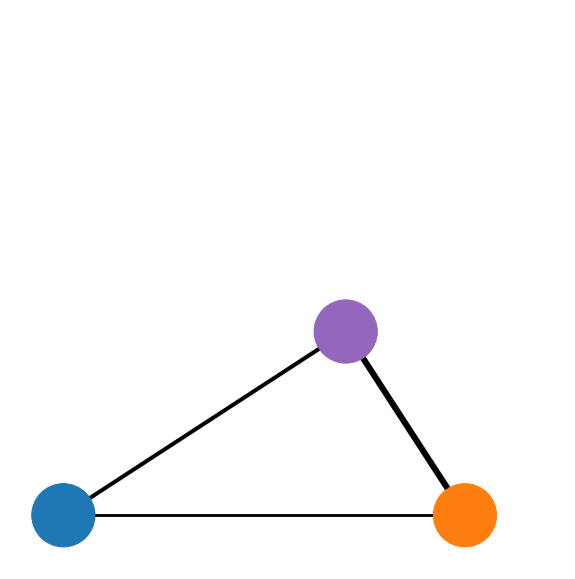

In [27]:
from numpy import array
G = nx.Graph()
G.add_node('Mast Progenitors', color='tab:blue')
G.add_node('Myeloid Progenitors', color='tab:orange')
G.add_node('Progenitor T Cells', color='tab:purple')
G.add_edge('Mast Progenitors', 'Myeloid Progenitors', 
           weight=real_sim_2['Real/Sim']['Mast Progenitors_Myeloid Progenitors'])
G.add_edge('Mast Progenitors', 'Progenitor T Cells', 
           weight=real_sim_2['Real/Sim']['Mast Progenitors_Progenitor T Cells'])
G.add_edge('Myeloid Progenitors', 'Progenitor T Cells', 
           weight=real_sim_2['Real/Sim']['Myeloid Progenitors_Progenitor T Cells'])

fig, ax = plt.subplots(figsize=(10,10))
labels = nx.get_edge_attributes(G,'weight')
# Because the weight of proT myeloid is greater than mast/myeloid + prot/mast we have to slightly modify the triangle
# as a result, the triangle side length is not perfectly proportionate to the weight
a = 1 - real_sim_2['Real/Sim']['Mast Progenitors_Myeloid Progenitors']
b = 1 - real_sim_2['Real/Sim']['Mast Progenitors_Progenitor T Cells']
c = 1 - real_sim_2['Real/Sim']['Myeloid Progenitors_Progenitor T Cells']
A = np.arccos((b**2+c**2-a**2)/(2*b*c))
B = np.arccos((a**2+c**2-b**2)/(2*a*c))
C = np.arccos((b**2+a**2-c**2)/(2*b*a))

prot_y = b*np.sin(C)
prot_x = b*np.cos(C)


pos={'Mast Progenitors': array([0,  0]),
     'Myeloid Progenitors': array([a, 0]),
     'Progenitor T Cells': array([prot_x, prot_y])}

colors1 = nx.get_node_attributes(G,'color').values()
weights = [G[u][v]['weight']*10 for u,v in G.edges()]
nx.draw(G, pos, node_color=colors1, width=weights, node_size=4000, ax=ax)

ax.set_xlim(left=-0.1, right=0.9)
ax.set_ylim(bottom=-.1, top=0.9)
plt.savefig('../../data/paper-figures/2cell-comp-graph.pdf', transparent=True)
plt.show()

# Make arrowhead matrix

In [28]:
sim_2_arrow = sim_2[['Mast Progenitors_Mast Progenitors', 'Myeloid Progenitors_Myeloid Progenitors',
                    'Progenitor T Cells_Progenitor T Cells', 'Myeloid Progenitors_Progenitor T Cells', 'Mast Progenitors_Progenitor T Cells',
                    'Mast Progenitors_Myeloid Progenitors']]

In [29]:
sim_2_arrow = sim_2_arrow.mean()

In [30]:
sim_2_arrow

Mast Progenitors_Mast Progenitors          2.585911
Myeloid Progenitors_Myeloid Progenitors    2.185369
Progenitor T Cells_Progenitor T Cells      1.927827
Myeloid Progenitors_Progenitor T Cells     0.613522
Mast Progenitors_Progenitor T Cells        0.402711
Mast Progenitors_Myeloid Progenitors       0.286322
dtype: float64

In [31]:
# Make plot
rev = ['Progenitor T Cells', 'Myeloid Progenitors', 'Mast Progenitors']
mtx = []
for x in rev:
    ls = []
    for y in rev:
        if x+'_'+y in sim_2_arrow.index:
            ls.append(sim_2_arrow[x+'_'+y])
        else:
            ls.append(1.5224)
    mtx.append(ls)

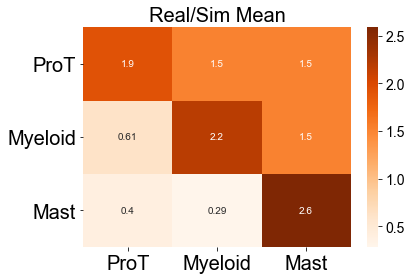

In [32]:
fix, ax = plt.subplots()
sns.heatmap(mtx, cmap='Oranges', ax=ax,
           annot=True,
           )
plt.title('Real/Sim Mean', fontsize=20)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['ProT', 'Myeloid', 'Mast'], fontsize=20, )
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['ProT', 'Myeloid', 'Mast'], rotation=0, fontsize=20)
plt.tight_layout()
plt.savefig('../../data/paper-figures/2cell-comp-arrow-head-mtx.pdf', dpi=150)
plt.show()

In [33]:
import anndata

In [34]:
mtx

[[1.9278269545684683, 1.5224, 1.5224],
 [0.6135223256193433, 2.1853688549805046, 1.5224],
 [0.40271130356774953, 0.28632161544390355, 2.585911181426548]]

In [35]:
mtx

[[1.9278269545684683, 1.5224, 1.5224],
 [0.6135223256193433, 2.1853688549805046, 1.5224],
 [0.40271130356774953, 0.28632161544390355, 2.585911181426548]]

In [36]:
sc.set_figure_params(dpi=150)
sc.settings.figdir = '../../data/paper-figures/'

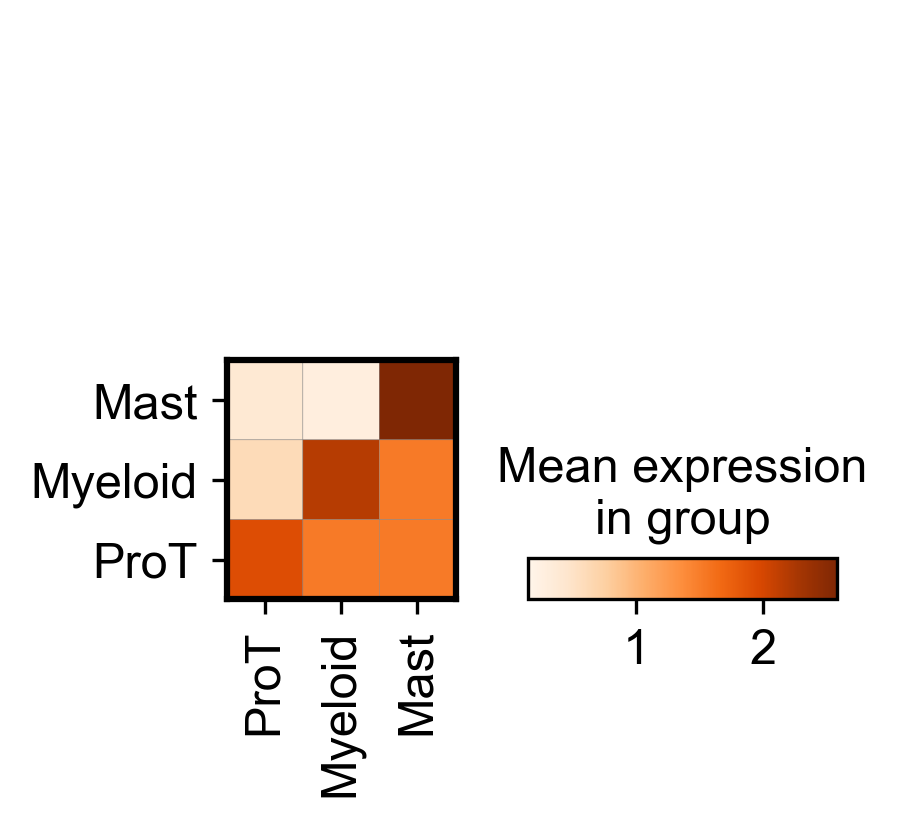

In [37]:
test = anndata.AnnData(X=np.array(mtx), var=['ProT', 'Myeloid', 'Mast'])
test.var_names = ['ProT', 'Myeloid', 'Mast']
test.obs_names = ['ProT', 'Myeloid', 'Mast']
test.obs["Type"] = ['ProT', 'Myeloid', 'Mast']
sc.pl.matrixplot(test, groupby='Type', var_names=['ProT', 'Myeloid', 'Mast'],
                cmap='Oranges', vmin=0.15,
                save='2cell-comp-arrow-head-mtx.pdf',)

d) T1 multitime w/ T1 multitime cells as comp

In [38]:
# make proper adata
T1_m_cells = []
for x in T1_multitime['Cells']:
    T1_m_cells += x

T1_m_adata = adata[adata.obs_names.isin(T1_m_cells)]

NameError: name 'T1_multitime' is not defined

In [ ]:
n_comps = 20000

# Two cell comparison for real dataset
real_comp = sample_clones(n_comps, T1_multitime)

print('Begin sim datasets')
# Get sim dataset
t1_clone_dist = list(T1_multitime[T1_multitime['Num Cells']>1]['Num Cells'])
sim = iterate_sims(1500, n_comps, T1_m_adata, t1_clone_dist)

real_sim_4 = combine_real_and_sim(real_comp, sim)

In [ ]:
real_sim_4

In [ ]:
colors = dict(zip(set(adata.obs['Cell Types']), adata.uns['Cell Types_colors']))
fig, ax = plt.subplots(nrows=1, ncols=1, sharey='row')
same_cols = ['Mast Progenitors_Mast Progenitors',
             'Erythroid Progenitors_Erythroid Progenitors',
             'Myeloid Progenitors_Myeloid Progenitors']
ax.bar(x=same_cols, height=[real_sim_4['Real/Sim'][x] for x in same_cols],
          color=[colors[x.split('_')[0]] for x in same_cols][0:-1]+['Red'])
ax.set_xticks(same_cols)
ax.set_xticklabels(same_cols, rotation=90)

# NOTE - NONE OF THESE COMBOS EXIST
# compare_cols = ['Mast Cells_Myeloid Cells', 'Mast Cells_Erythroid Cells', 'Myeloid Cells_Erythroid Cells']
# ax[1].bar(x=compare_cols, height=[real_sim_4['Real/Sim'][x] for x in compare_cols],
#           color=['yellow', 'lightblue', 'pink'])
# ax[1].set_xticklabels(compare_cols, rotation=90)
plt.show()

In [ ]:
sc.pl.umap(T1_m_adata, color='Cell Types')

In [ ]:
sc.pl.umap(T2_m_adata, color='Cell Types')